In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [3]:
def load_data(file_path):
  df = pd.read_excel(file_path)
  df = df.rename(columns = {"T2M":"temp", "CLRSKY_SFC_SW_DWN":"clear_sky_rad", "ALLSKY_SFC_SW_DWN":"all_sky_rad", "Value":"power" })
  df = df[['temp', 'clear_sky_rad', 'all_sky_rad', "power"]]
  return df

In [4]:
file_path = "/content/cleaned_data_for_solar_forecasting.xlsx"
df = load_data(file_path)
df

,temp,clear_sky_rad,all_sky_rad,power
0,27.20,0.0,0.0,0.0
1,26.74,0.0,0.0,0.0
2,26.51,0.0,0.0,0.0
3,26.23,0.0,0.0,0.0
4,26.09,0.0,0.0,0.0
...,...,...,...,...
31435,18.55,0.0,0.0,0.0
31436,17.77,0.0,0.0,0.0
31437,17.02,0.0,0.0,0.0
31438,16.32,0.0,0.0,0.0


In [5]:
int(31440/24) # train -> 1000, valid -> 100, test -> 210

1310

In [6]:
def check_nans(df):
  x = df.isnull().sum().sum()
  print(x)

In [7]:
check_nans(df)

0


In [8]:
def plot_cols(df):
  fig, axs = plt.subplots(4, figsize=(10, 8))
  fig.suptitle('Plotting the columns of the data')
  for i, col in enumerate(df.columns):
    axs[i].plot(df[col])

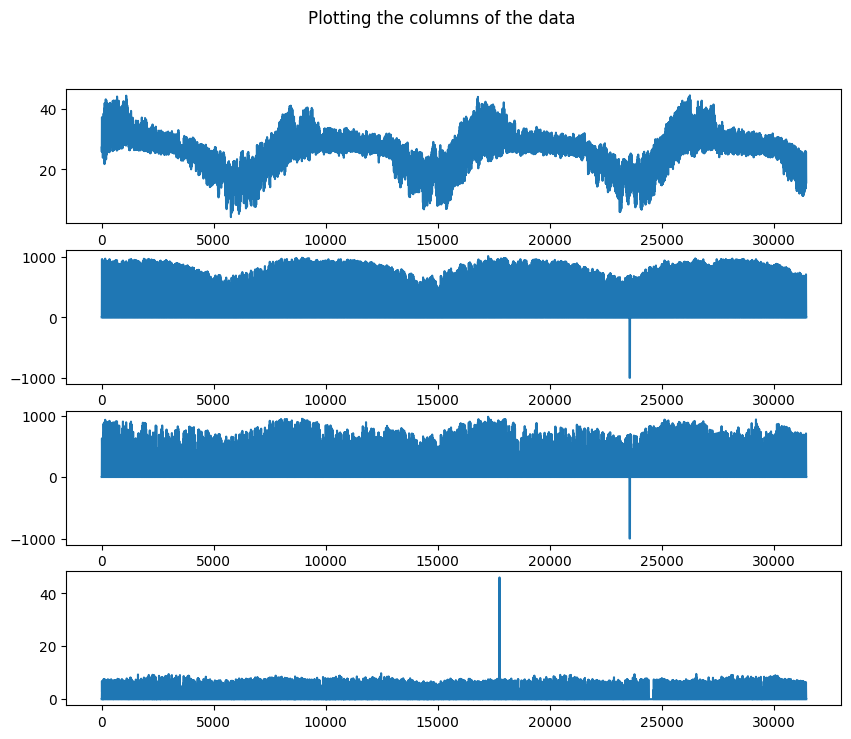

In [9]:
plot_cols(df)

In [10]:
def clean_negatives(df):
  df = df.mask(df<0, 0)
  return df

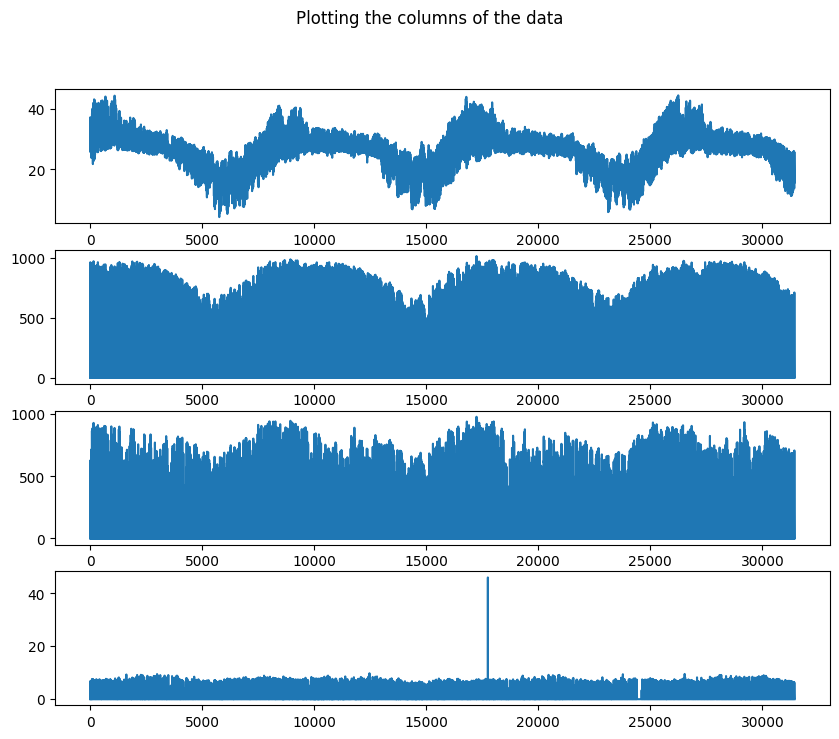

In [11]:
df = clean_negatives(df)
plot_cols(df)

In [12]:
# as we don't have anamolies in the power productions we can remove the spike in the power graph
np.where(df.power > 20)
df.power.iloc[17751] = 7
df.power.iloc[17751]

7.0

In [13]:
np.sum(df.power>7.5)

438

In [14]:
df.power

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
31435    0.0
31436    0.0
31437    0.0
31438    0.0
31439    0.0
Name: power, Length: 31440, dtype: float64

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df.power[24*30:24*70])
plt.show()

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  i = 1
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [f'var{df.columns[j]}(t-{i})' for j in range(n_vars)]

  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i==0:
      names += [f'var{df.columns[j]}(t)' for j in range(n_vars)]
    else:
      names += [f'var{df.columns[j](t+{i})}' for j in range(n_vars)]
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  if dropnan==True:
    agg.dropna(inplace=True)
  return agg

In [ ]:
df

In [ ]:
def normalize_features(df):
  values = df.values
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  return scaled

In [ ]:
[i for i in range(4*32, 4*33-1)]

In [ ]:
prev_hour_lookback = 4 # 24

In [ ]:
scaled = normalize_features(df)
reframed = series_to_supervised(scaled, prev_hour_lookback, 1) # --> tune
reframed.drop(reframed.columns[[i for i in range(4*prev_hour_lookback, 4*(prev_hour_lookback+1)-1)]], axis=1, inplace=True)

In [ ]:
reframed

In [ ]:
days = 31440/24
train_days = int(days*0.8)
test_days = int(days*0.2)
train_days, test_days

In [ ]:
days

In [ ]:
values = reframed.values
train_hours = train_days*24
train = values[:train_hours, :]
# valid = values[1000*24:1100*24, :]
test = values[train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

#### Reshaping the data

In [ ]:
# train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
# test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

# train_X.shape, train_y.shape, test_X.shape, test_y.shape

***Shape of the data : (samples , time_steps, features)***

***y_train : (time_steps, samples)***

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(train_X, train_y)
preds = xgb_model.predict(test_X)
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual Values')
plt.plot(preds, label='Predicted Values')
plt.xlabel('Time Steps (Hours)')
plt.ylabel('Value')
plt.title('Predicted Values vs. Actual Values for Test Data')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, preds)